In [1]:
'''
见下面的jpg  m=3  b=6  v=16    d=2  h=5
attention中分为三大快     encode,decode
input =  ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]   (m,b,v)=(3,6,16)
output = [1, 1, 1, 0, 0, 0]   (b,o)=(6,2)



input: (m,b,v)====>(m,b,d)
#input和随机初始化的hidden和cell做LSTM操作，得到output:(m,b,2*h),    final_hidden_state, final_cell_state : =(2,b,h)

# final_hidden_state:(b,2*h)和output:(m,b,2*h),的每一层(b,2*h)内积和操作得到m层(1,b),即(m,1,b),然后softmax操作得attention=(b,m,1)====>m方向softmax===(b,m,1)
bmm(  (b,m,2*h),(b,2*h,1) ) = (b,m,1)  

#output:(b,2*h,m) 和 attention：(b,m,1) 运行bmm（batch  matrix multip)操作得到context= （b,2*h,1）     
#                                                      <=============>  等效于每一层output和其attention的乘积，然后相加
bmm( (b,2*h,m ),(b,m,1） ） = （b,2*h,1）   



#输出
(o,2*h) * (2*h,b) = (o,b)
(o,b)和ouput运行交叉熵得到loss，反向传播



#test操作：
input = 'i hate baseball'   #(b,m,v)=(1,3,16)========>(b,m,d)
判断输出是0或1

predict, _ = model(test_batch)                     # predict : (b,o) =(1,2)
# print(predict)                                   # tensor([[ 2.3760, -2.8618]])
# print(predict.data.max(1,keepdim=True))          #是元组   (tensor([[ 2.3760]]) , tensor([[ 0]]))
predict = predict.data.max(1, keepdim=True)[1]     # tensor([[ 0]]))
if predict[0][0] == 0:                             # 表示元组的第二位是0，元组的第一位是最大值，即输出为0===>bad
    print("'"+test_text+"'      ","is Bad")
else:
    print("'"+test_text+"'      ","is Good ")

'''

'\nv=vocab_size=16\nb=batch_size=6\nm=max_len=3\nd=embedding_dim = 2\nh= n_hidden = 5 \no=num_classes = 2         # 0 or 1\n\n'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

dtype = torch.FloatTensor

# Bi-LSTM(Attention) Parameters
embedding_dim = 2
n_hidden = 5 # number of hidden units in one cell
num_classes = 2  # 0 or 1

# 3 words sentences (=sequence_length is 3)
sentences = ["i love you", "he loves me", "she likes baseball", "i hate you", "sorry for that", "this is awful"]
labels = [1, 1, 1, 0, 0, 0]  # 1 is good, 0 is not good.

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
vocab_size = len(word_dict)


print('word_list=',word_list)
print('word_dict=',word_dict)
print("vocab_size = " ,vocab_size)

word_list= ['he', 'awful', 'she', 'baseball', 'hate', 'sorry', 'i', 'that', 'you', 'likes', 'is', 'this', 'love', 'me', 'loves', 'for']
word_dict= {'he': 0, 'awful': 1, 'she': 2, 'baseball': 3, 'hate': 4, 'sorry': 5, 'i': 6, 'that': 7, 'you': 8, 'likes': 9, 'is': 10, 'this': 11, 'love': 12, 'me': 13, 'loves': 14, 'for': 15}
vocab_size =  16


In [3]:
inputs = []
for sen in sentences:
    inputs.append(np.asarray([word_dict[n] for n in sen.split()]))
print(inputs)

targets = []
for out in labels:
    targets.append(out)         # To using Torch Softmax Loss function

input_batch = Variable(torch.LongTensor(inputs))
target_batch = Variable(torch.LongTensor(targets))
print("input=",input_batch.size())
print("target=",target_batch.size())

[array([ 6, 12,  8]), array([ 0, 14, 13]), array([2, 9, 3]), array([6, 4, 8]), array([ 5, 15,  7]), array([11, 10,  1])]
input= torch.Size([6, 3])
target= torch.Size([6])


In [4]:
class BiLSTM_Attention(nn.Module):
    def __init__(self):
        super(BiLSTM_Attention, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)   #(v,d)
        self.lstm = nn.LSTM(embedding_dim, n_hidden, bidirectional=True)
        self.out = nn.Linear(n_hidden * 2, num_classes)  #(2*h,o)

    # lstm_output : [b,m, h * num_directions(=2)] = (b,m,2*h)
    def attention_net(self, lstm_output, final_state):
        hidden = final_state.view(-1, n_hidden * 2, 1)   # hidden : (2,b,h)====>(b,2*h,1) =(b,hidden * num_directions(=2), n_layer)
        attn_weights = torch.bmm(lstm_output, hidden).squeeze(2) #bmm(  (b,m,2*h),(b,2*h,1) ) = (b,m,1)
        soft_attn_weights = F.softmax(attn_weights, 1)        #soft_attn_weights =(b,m)  沿着m方向softmax操作
        
        #bmm( (b,2*h,m ),(b,m,1） ） = （b,2*h,1)  =======>squeeze(2)操作==>(b,2*h)
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)    
        return context, soft_attn_weights.data.numpy() # context : (b,2*h)

    def forward(self, X):  #X:(b,m)
        input = self.embedding(X) # input : (b,m,d)
        input = input.permute(1, 0, 2) # (b,m,d)====>(m,b,d)

        hidden_state = Variable(torch.zeros(1*2, len(X), n_hidden)) # [num_layers(=1) * num_directions(=2), b, h]=(2,b,h)
        cell_state = Variable(torch.zeros(1*2, len(X), n_hidden)) # [num_layers(=1) * num_directions(=2), b, h]=(2,b,h)

        # output:(m,b,2*h)                     final_hidden_state, final_cell_state : [num_layers(=1) * num_directions(=2), b, h]=(2,b,h)
        output, (final_hidden_state, final_cell_state) = self.lstm(input, (hidden_state, cell_state)) # self.lstm(  (m,b,d),  ( (2,b,h),(2,b,h)  )   )
        output = output.permute(1, 0, 2) # output :(m,b,2*h) ==>(b,m,2*h)
        attn_output, attention = self.attention_net(output, final_hidden_state)        # self.attention_net(  (b,m,2*h),(2,b,h) )
        #attn_ouput: (b,2*h)          # model : (2*h,o)*(b,2*h) = (b,o)          attention : (b,m))
        return self.out(attn_output), attention 


model = BiLSTM_Attention()
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
for epoch in range(10000):
    optimizer.zero_grad()
    #output : (b,o)          attention : (b,m)
    output, attention = model(input_batch)    #mode( (b,m) )  = model( (6,3) )

    loss = criterion(output, target_batch)   # criterion(  (b,o),  (b) )   
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

BiLSTM_Attention(
  (embedding): Embedding(16, 2)
  (lstm): LSTM(2, 5, bidirectional=True)
  (out): Linear(in_features=10, out_features=2, bias=True)
)


Epoch: 1000 cost = 0.003527


Epoch: 2000 cost = 0.000817


Epoch: 3000 cost = 0.000318


Epoch: 4000 cost = 0.000150


Epoch: 5000 cost = 0.000078


Epoch: 6000 cost = 0.000042


Epoch: 7000 cost = 0.000024


Epoch: 8000 cost = 0.000014


Epoch: 9000 cost = 0.000008


Epoch: 10000 cost = 0.000005


'i hate baseball'       is Bad


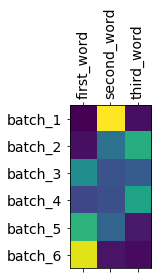

In [6]:
# Test
test_text = 'i hate baseball'
tests = [np.asarray([word_dict[n] for n in test_text.split()])]
test_batch = Variable(torch.LongTensor(tests))

predict, _ = model(test_batch)      # predict : (b,o) =(1,2)
# print(predict)                     #tensor([[ 2.3760, -2.8618]])
# print(predict.data.max(1,keepdim=True))  #是元组   (tensor([[ 2.3760]]) , tensor([[ 0]]))
predict = predict.data.max(1, keepdim=True)[1]     #tensor([[ 0]]))
if predict[0][0] == 0:            #表示元组的第二位是0，元组的第一位是最大值，即输出为0===>bad
    print("'"+test_text+"'      ","is Bad")
else:
    print("'"+test_text+"'      ","is Good ")
    
fig = plt.figure(figsize=(6, 3)) # [batch_size, n_step]
ax = fig.add_subplot(1, 1, 1)
ax.matshow(attention, cmap='viridis')
ax.set_xticklabels(['']+['first_word', 'second_word', 'third_word'], fontdict={'fontsize': 14}, rotation=90)
ax.set_yticklabels(['']+['batch_1', 'batch_2', 'batch_3', 'batch_4', 'batch_5', 'batch_6'], fontdict={'fontsize': 14})
plt.show()